In [1]:
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from pathlib import Path
import scipy.ndimage.measurements as measurements
from rscube import (apply_func_to_superpixels,
                    get_array_from_features,
                    get_superpixel_means_as_features,
                    get_superpixel_stds_as_features)
from tqdm import tqdm
from itertools import starmap

# Opening the Rasters

In [2]:
DATA_DIR = Path('data/datacube_ROI')
DATA_DIR.exists()

True

In [3]:
def open_one(path):
    with rasterio.open(path) as ds:
        arr = ds.read(1)
    return arr

In [4]:
hansen_paths = sorted(list(DATA_DIR.glob('hansen*.tif')))
hansen_arrs = list(map(open_one, tqdm(hansen_paths)))

100%|██████████| 4/4 [00:00<00:00, 17.12it/s]


In [5]:
uavsar_paths = sorted(list(DATA_DIR.glob('UAVSAR*.tif')))
uavsar_arrs = list(map(open_one, tqdm(uavsar_paths)))

100%|██████████| 3/3 [00:00<00:00, 19.96it/s]


# Opening the Superpixels

In [6]:
with rasterio.open('out/superpixels.tif') as ds:
    superpixel_labels = ds.read(1)
    profile = ds.profile

profile['dtype'] = 'float32'
profile['nodata'] = np.nan

# Aggregating the Raster Data within a Superpixel Segment


## Getting the Features

We obtain features for each superpixel, which provide us away to match each segment with its aggregated statistic. We call them "features" because these can be directly used with [`sklearn`](https://scikit-learn.org/stable/)'s API.

Each feature array is of the form features $K \times 1$ where $K$ are the number of superpixels segments. Skimage and our earlier bookkeeping ensures that are labels are of the form 0, 1, 2, ... K, so that each index of the mean feature is also its label, which makes subsequent lookup very fast.

In [7]:
def get_superpixel_means_as_features_partial(img):
    return get_superpixel_means_as_features(superpixel_labels, img)
hansen_mean_features = list(map(get_superpixel_means_as_features_partial, tqdm(hansen_arrs)))
hansen_std_features = list(map(get_superpixel_means_as_features_partial, tqdm(hansen_arrs)))

100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


In [8]:
# The number of label x 1
hansen_mean_features[0].shape

(138015, 1)

In [9]:
# The maximum should be precicesely the number of labels - 1 (because we also have the mask)
superpixel_labels.max()

138014

Let's now do the same for UAVSAR.

In [10]:
uavsar_mean_features = list(map(get_superpixel_means_as_features_partial, tqdm(uavsar_arrs)))
uavsar_std_features = list(map(get_superpixel_means_as_features_partial, tqdm(uavsar_arrs)))

100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


In [11]:
def get_array_from_features_partial(features):
    arr = get_array_from_features(superpixel_labels, features)
    return arr

In [12]:
hansen_mean_arrs = list(map(get_array_from_features_partial, tqdm(hansen_mean_features)))
hansen_std_arrs = list(map(get_array_from_features_partial, tqdm(hansen_std_features)))

100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


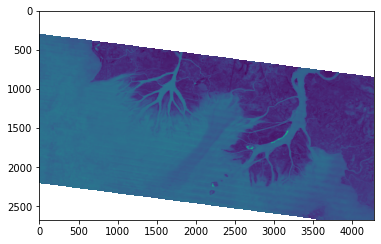

In [13]:
plt.imshow(hansen_mean_arrs[0])

In [14]:
uavsar_mean_arrs = list(map(get_array_from_features_partial, tqdm(uavsar_mean_features)))
uavsar_std_arrs = list(map(get_array_from_features_partial, tqdm(uavsar_std_features)))

100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


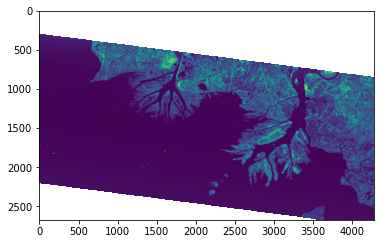

In [15]:
plt.imshow(uavsar_mean_arrs[0])

In [16]:
df_superpixels = gpd.read_file('out/superpixels')

In [17]:
def get_features(label, feature_arr):
    return float(feature_arr[label])

df_superpixels['hansen_3_mean'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_mean_features[0]))
df_superpixels['hansen_4_mean'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_mean_features[1]))
df_superpixels['hansen_5_mean'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_mean_features[2]))
df_superpixels['hansen_7_mean'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_mean_features[3]))

df_superpixels['hansen_3_std'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_std_features[0]))
df_superpixels['hansen_4_std'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_std_features[1]))
df_superpixels['hansen_5_std'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_std_features[2]))
df_superpixels['hansen_7_std'] = df_superpixels['label'].map(lambda l: get_features(l, hansen_std_features[3]))

df_superpixels['hh_mean'] = df_superpixels['label'].map(lambda l: get_features(l, uavsar_mean_features[0]))
df_superpixels['hv_mean'] = df_superpixels['label'].map(lambda l: get_features(l, uavsar_mean_features[1]))
df_superpixels['vv_mean'] = df_superpixels['label'].map(lambda l: get_features(l, uavsar_mean_features[2]))

df_superpixels['hh_std'] = df_superpixels['label'].map(lambda l: get_features(l, uavsar_std_features[0]))
df_superpixels['hv_std'] = df_superpixels['label'].map(lambda l: get_features(l, uavsar_std_features[1]))
df_superpixels['vv_std'] = df_superpixels['label'].map(lambda l: get_features(l, uavsar_std_features[2]))

<AxesSubplot:>

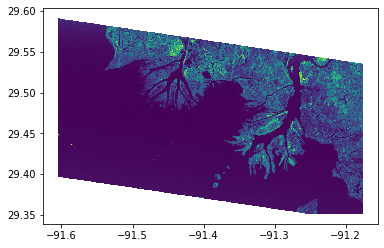

In [18]:
df_superpixels.plot(column='hh_mean')

In [19]:
df_superpixels.to_file('out/df_superpixels_with_attributes')

In [20]:
def write_one(arr, dest_path):
    with rasterio.open(dest_path, 'w', **profile) as ds:
        ds.write(arr.astype(np.float32), 1)
    return dest_path

In [21]:
dest_dir = Path('out/aggregated_superpixel_statistics_rasters')
dest_dir.mkdir(exist_ok=True, parents=True)

In [22]:
dest_paths = [dest_dir/f'hansen_mean_{k}.tif' for k in [3, 4, 5, 7]]
list(starmap(write_one, zip(hansen_mean_arrs, tqdm(dest_paths))))

 75%|███████▌  | 3/4 [00:00<00:00,  4.40it/s]


[PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_mean_3.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_mean_4.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_mean_5.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_mean_7.tif')]

In [23]:
dest_paths = [dest_dir/f'hansen_std_{k}.tif' for k in [3, 4, 5, 7]]
list(starmap(write_one, zip(hansen_mean_arrs, tqdm(dest_paths))))

 75%|███████▌  | 3/4 [00:00<00:00,  4.18it/s]


[PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_std_3.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_std_4.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_std_5.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/hansen_std_7.tif')]

In [24]:
dest_paths = [dest_dir/f'uavsar_{pol}_mean.tif' for pol in ['hh', 'hv', 'vv']]
list(starmap(write_one, zip(uavsar_mean_arrs, tqdm(dest_paths))))

 67%|██████▋   | 2/3 [00:00<00:00,  3.78it/s]


[PosixPath('out/aggregated_superpixel_statistics_rasters/uavsar_hh_mean.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/uavsar_hv_mean.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/uavsar_vv_mean.tif')]

In [30]:
dest_paths = [dest_dir/f'uavsar_{pol}_std.tif' for pol in ['hh', 'hv', 'vv']]
list(starmap(write_one, zip(tqdm(uavsar_std_arrs), dest_paths)))

100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


[PosixPath('out/aggregated_superpixel_statistics_rasters/uavsar_hh_std.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/uavsar_hv_std.tif'),
 PosixPath('out/aggregated_superpixel_statistics_rasters/uavsar_vv_std.tif')]